<a href="https://colab.research.google.com/github/Renan-Domingues/Learn-PyTorch-in-a-day-Daniel-Bourk/blob/main/02_pytorch_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*CLASSIFICATION = PREDICT A THING

*REGRETION = PREDICT A NUMBER  # Regretion foi o módulo anterior

# Neural network classification with PyTorch
Classification is a problem of predicting whether something is one thing or another (there can  be multiple things as the options).

## Make classification data and get it read

In [1]:
import sklearn

In [2]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create Circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
print(f"First 5 samples of X:\n {X[:5]}")
print(f"First 5 samples of y:\n {y[:5]}")

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [5]:
# Make dataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


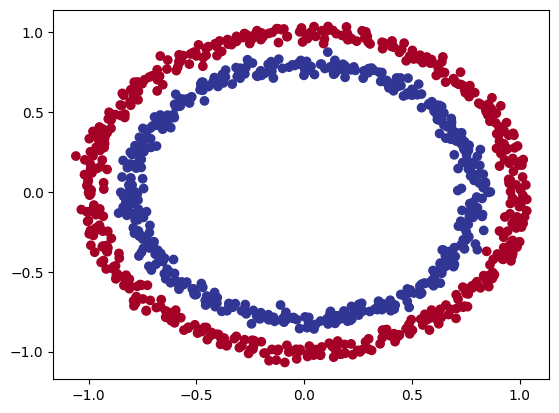

In [6]:
# visualise
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);

Note: The data we are working with is often referred to as a toy dataset, a dataset that is small enough to experiment but still sizeable enoght to practice the fundamentals.

### 1.1 Check input and output shapes


In [7]:
X.shape, y.shape

((1000, 2), (1000,))

In [8]:
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [9]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors and create train and test splits

In [10]:
import torch
torch.__version__

'2.0.1+cu118'

In [11]:
type(X)

numpy.ndarray

In [12]:
# Turn data into Tensors
X = torch.from_numpy(X).type(torch.float) # Convertendo em float32, que é o defaut do torch (não precisa colocar o 32 pq ele faz por padrão)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [13]:
type(X), X.dtype, y.dtype # Foi transformado em tensor e em float32

(torch.Tensor, torch.float32, torch.float32)

In [14]:
# split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 0.2 = 20% of data will be test & 80% will be train
                                                    random_state=42)

In [15]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## Buiding a model

Let's buid a model to classify our blue and red dots.

to do so, we want to:
1. Setup device agnostic code so our code will run on a accelerator (GPU) if there is one
2. Construct a model (by subclassing `nn.Module`)
3. Define a loss function and optimizer
4. Create a training and test loop

In [16]:
# import PyTorch and nn
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [17]:
X_train

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        ...,
        [ 0.0157, -1.0300],
        [ 1.0110,  0.1680],
        [ 0.5578, -0.5709]])

Now we've setup the device agnostic code, let's create a model that:

1. Subclass `nn.Module` (almost all models in PyTorch subclass `nn.Module`)
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of out data
3. Defines a `foward()` method that outlines the forward pass (or forward computation) of the model.
4.Instantiate a instance of our model class and send it to the target `device`

In [18]:
X_train.shape

torch.Size([800, 2])

In [19]:
# Construct a model that subclass nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. Create 2 nn.Linear layers capable of handling the shapes of our data
    self.layer_1 = nn.Linear(in_features=2, out_features=5) # take in 2 features and upscale to 5 features
    self.layer_2 = nn.Linear(in_features=5, out_features=1) # take in 5 features from previous layer and outputs a single feature (same shape as y)

  # 3. Define a forward method that outlines the forward pass
  def forward(self, x):
    return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output

# 4. instantiate a instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [20]:
# Let's replicate the model above using nn.Sequential()

model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [21]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.6149,  0.0033],
                      [ 0.2826, -0.0716],
                      [-0.4665, -0.0123],
                      [ 0.0875,  0.0307],
                      [ 0.3102,  0.5251]], device='cuda:0')),
             ('0.bias',
              tensor([-0.0826,  0.6871, -0.3139,  0.1473,  0.4175], device='cuda:0')),
             ('1.weight',
              tensor([[-0.2775,  0.3416,  0.4007,  0.2764, -0.3422]], device='cuda:0')),
             ('1.bias', tensor([0.0830], device='cuda:0'))])

In [22]:
# Make predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Lenght of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test examples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 prediction:\n{torch.round(untrained_preds[:10])}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")

Lenght of predictions: 200, Shape: torch.Size([200, 1])
Length of test examples: 200, Shape: torch.Size([200, 2])

First 10 prediction:
tensor([[-0.],
        [-0.],
        [0.],
        [-0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [-0.]], device='cuda:0')

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [23]:
X_test[:10], y_test[:10]

(tensor([[-0.3752,  0.6827],
         [ 0.0154,  0.9600],
         [-0.7028, -0.3147],
         [-0.2853,  0.9664],
         [ 0.4024, -0.7438],
         [ 0.6323, -0.5711],
         [ 0.8561,  0.5499],
         [ 1.0034,  0.1903],
         [-0.7489, -0.2951],
         [ 0.0538,  0.9739]]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

 ### Setup a loss function and a optimizer
 Which loss function or optimizer shoud you use?

 Again... this is problem specific

 For exemple, for regression you might want MAE or MSE (mean absolut error or mean squared error).

 For classification you might want binary cross entropy or  categorical cross entropy (cross entropy).

 As a reminder, the loss function measures how *wrong* yours model predictions are.

 And for optimizers, two of the most common and useful are SGD and Adam, however PyTorch has many built-in options.

 * For the loss function we're going to use `torch.nn.BECWithLogitsLoss()`, for more on what binary cross entropy (BCE) is, 10:04:53 from the video, there are some links
 * For different optimizers see `torch.optim`

In [24]:
# Setup the loss function

loss_fn  = nn.BCEWithLogitsLoss() #BCEWithLogitsLoss = sigmoid activation function buit-in

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [25]:
#Calculate accuracy - out of 100 examples, what percentege does our model get right?
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

## 3. Train model

To train a model, we going to need a training loop with the following steps

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward (Backpropagation)
5. Optimizer step (Gradient descent)

### Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits**.

We can cover this **logits** into prediction probabilities by passing them to some kind of activation function (e.g. sigmoid for binery crossentropy and softmax for multiclass classification)

Then we can convert our model's prediction probabilities to prediction labels by  either round them or taking the argmax().

In [26]:
#View the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.0242],
        [-0.0807],
        [ 0.1773],
        [-0.0815],
        [ 0.2619]], device='cuda:0')

In [27]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [28]:
# Use a sigmoid activation function on our model logits to turn then in to prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4940],
        [0.4798],
        [0.5442],
        [0.4796],
        [0.5651]], device='cuda:0')

For our prediction probability values, we need to perform a range-style round on them:
*`y_pred_probs` >= 0.5, `y=1` (class 1)
*`y_pred_probs` < 0.5, `y=0` (class 2)

In [29]:
# find our predicted labels
y_preds = torch.round(y_pred_probs)

# in full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimensions
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 1., 0., 1.], device='cuda:0')

In [30]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

### Buiding a training test loop

In [31]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# buid training and evaluation loop

for epoch in range(epochs):
  ### training
  model_0.train()

  # 1. forward  pass
  y_logits = model_0(X_train).squeeze()
  y_pred =  torch.round(torch.sigmoid(y_logits)) # -> turn logis into pred probs -> pred labels

  # 2. Calculate loss/accuracy
  loss = loss_fn(y_logits,
                 y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward (backpropagation)
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. forward pass
    test_logits =  model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Caclculate the test loss/acc
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc  = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

    # Print out what's happening
  if epoch %10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss {test_loss:.5f}, test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69798, Acc: 52.88% | Test loss 0.69206, test acc: 53.50%
Epoch: 10 | Loss: 0.69647, Acc: 50.25% | Test loss 0.69126, test acc: 55.00%
Epoch: 20 | Loss: 0.69572, Acc: 50.12% | Test loss 0.69109, test acc: 55.50%
Epoch: 30 | Loss: 0.69524, Acc: 50.12% | Test loss 0.69112, test acc: 53.00%
Epoch: 40 | Loss: 0.69488, Acc: 49.50% | Test loss 0.69122, test acc: 53.50%
Epoch: 50 | Loss: 0.69460, Acc: 49.75% | Test loss 0.69136, test acc: 53.00%
Epoch: 60 | Loss: 0.69436, Acc: 49.88% | Test loss 0.69151, test acc: 53.50%
Epoch: 70 | Loss: 0.69416, Acc: 50.00% | Test loss 0.69166, test acc: 54.00%
Epoch: 80 | Loss: 0.69400, Acc: 49.75% | Test loss 0.69182, test acc: 53.50%
Epoch: 90 | Loss: 0.69385, Acc: 49.38% | Test loss 0.69197, test acc: 53.00%


# 4. Make predictions and evaluate the model
from the metrics it looks like our model isn't learn anything...

so to inspect it let's make some predictions and make them visual

to do so, we're going to import a function called  `plot_decision_bondary()`

In [32]:
import requests
from pathlib import Path


# Download helper function from learn pytorch repo (if it's not aready downloaded)

if Path("helper_functions.py").is_file():
  print("helper_functions.py aready exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

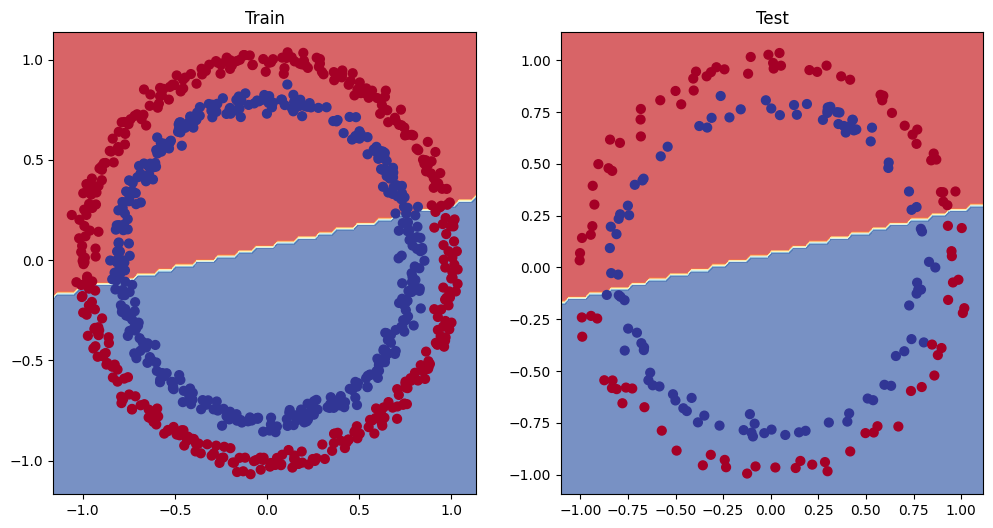

In [33]:
# Plot decision boundary of the model

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improve a Model (from a model perspective)

* Add more layers - Give the model more chances to learn about the patterns in our data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer (more epochs)
* Changing the activation functions
* Changing the learning rate no optimizer (lr=?)
* Change the loss function (it's not the case for now)

MODEL PERSPECTIVE because they deal directly with the model, rather than the data.

In [34]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    # z = self.layer_1(x)
    # z = self.layer_2(z)
    # z = self.layer_3(z)
    # return z              Poderia fazer assim, mas a versão a seguir usa menos linhas de código
    return self.layer_3(self.layer_2(self.layer_1(x))) # This way is faster bihind the scenes

model_1 =  CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [35]:
model_1.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]], device='cuda:0')),
             ('layer_1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984], device='cuda:0')),
             ('layer_2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.122

In [36]:
# Create a loss function

loss_fn = nn.BCEWithLogitsLoss()

# Create a optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [37]:
# Create a trining and evaluation loop for model_1
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# train for longer
epochs = 1000

# Put data in the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test =  X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  ### Training
  model_1.train()

  # 1. Forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

  # 2. Calculate the loss/acc
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward (backpropagation)
  loss.backward()

  # 5. Optimize step (gradient descent)
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    # 1. forward pass
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    # 2. Calculate loss
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

    # 3. Print out wht's happenin
    if epoch %100 == 0:
      print(f"Eporch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Eporch: 0 | Loss: 0.69396, Acc: 50.88% | Test Loss: 0.69261, Test acc: 51.00%
Eporch: 100 | Loss: 0.69305, Acc: 50.38% | Test Loss: 0.69379, Test acc: 48.00%
Eporch: 200 | Loss: 0.69299, Acc: 51.12% | Test Loss: 0.69437, Test acc: 46.00%
Eporch: 300 | Loss: 0.69298, Acc: 51.62% | Test Loss: 0.69458, Test acc: 45.00%
Eporch: 400 | Loss: 0.69298, Acc: 51.12% | Test Loss: 0.69465, Test acc: 46.00%
Eporch: 500 | Loss: 0.69298, Acc: 51.00% | Test Loss: 0.69467, Test acc: 46.00%
Eporch: 600 | Loss: 0.69298, Acc: 51.00% | Test Loss: 0.69468, Test acc: 46.00%
Eporch: 700 | Loss: 0.69298, Acc: 51.00% | Test Loss: 0.69468, Test acc: 46.00%
Eporch: 800 | Loss: 0.69298, Acc: 51.00% | Test Loss: 0.69468, Test acc: 46.00%
Eporch: 900 | Loss: 0.69298, Acc: 51.00% | Test Loss: 0.69468, Test acc: 46.00%


### Preparing our data to see with the model can fit a straight line

One way to troubleshoot to a larger problem is to test out a smaller problem.

In [38]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # Linear regression formula

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [39]:
# Create train and test splits
train_split = int(0.8 * (len(X_regression)))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each
len(X_train_regression), len(X_test_regression), len(y_train_regression), len(y_test_regression)

(80, 20, 80, 20)

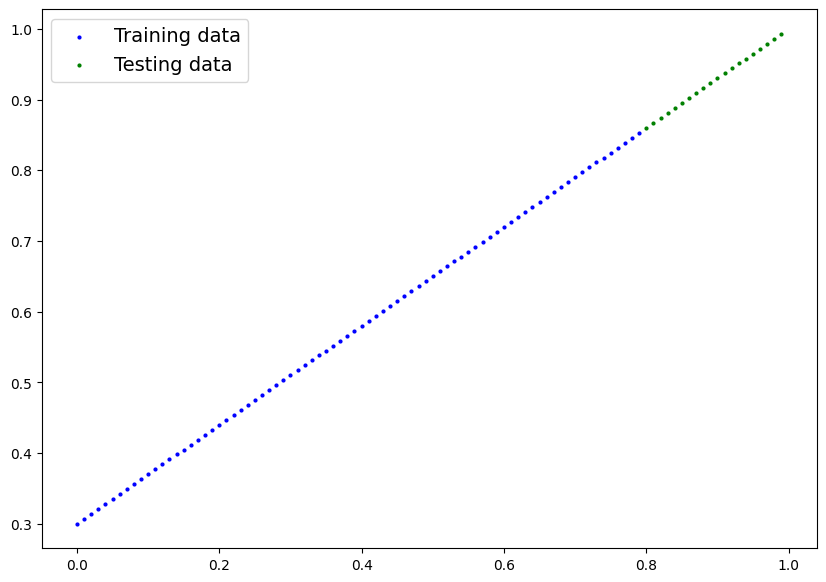

In [40]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression);

In [41]:
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

### Ajusting model_1 to fit a straight line

In [42]:
# Same architecture as model_1 (but using nn.Sequential())
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [43]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.0001)


In [44]:
# train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put the data on the target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

# Training
for epoch in range(epochs):
  y_pred = model_2(X_train_regression)
  loss = loss_fn(y_pred, y_train_regression)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Testing
  model_2.eval()
  with torch.inference_mode():
    test_pred = model_2(X_test_regression)
    test_loss = loss_fn(test_pred, y_test_regression)

  # Print out whats happenin
  if epoch % 100 == 0:
    print(f"Epoch {epoch} | Loss: {loss:.5f} | Test loss {test_loss:.5f}")


Epoch 0 | Loss: 0.75986 | Test loss 0.95353
Epoch 100 | Loss: 0.72217 | Test loss 0.91073
Epoch 200 | Loss: 0.68506 | Test loss 0.86850
Epoch 300 | Loss: 0.64848 | Test loss 0.82678
Epoch 400 | Loss: 0.61238 | Test loss 0.78551
Epoch 500 | Loss: 0.57669 | Test loss 0.74462
Epoch 600 | Loss: 0.54137 | Test loss 0.70406
Epoch 700 | Loss: 0.50636 | Test loss 0.66376
Epoch 800 | Loss: 0.47162 | Test loss 0.62366
Epoch 900 | Loss: 0.43710 | Test loss 0.58371


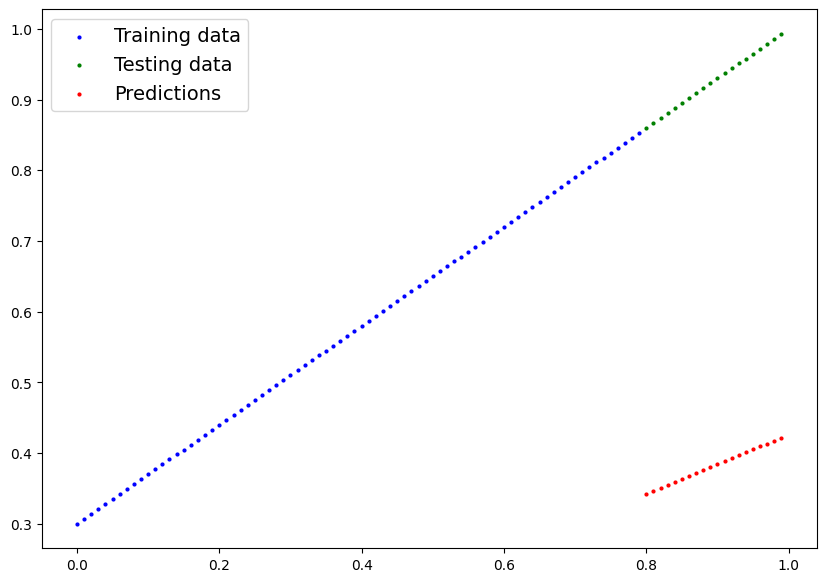

In [45]:
# Turn on the evaluation mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
  y_preds = model_2(X_test_regression)

# Plot data and predictions
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu());

## 6. The missing piece: non-linearity

"What patterns could you draw if you are given an  infinite amount of straight and non-straight lines?"

Or in machine learning terms, an infinite (but really it is finite) of linear and non-linear functions?

### 6.1 Recriating non-linear data (red and blue circles)

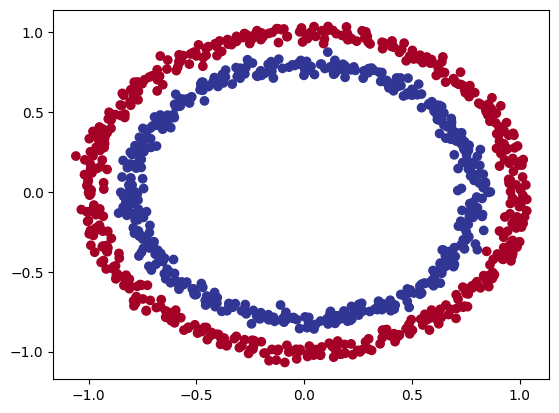

In [46]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y  =  make_circles(n_samples,
                      noise=0.03,
                      random_state=42)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

In [47]:
# Convert data to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### Building a model  with non-linearty

* Linear = straight line
* Non-linear = non-straight lines

Artificial neural networks are a large combination of linear (straight) and non-straight (non-linear) functions wich are potentially able to find patterns in data

In [48]:
# Build a model with non-linear activation functions
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU() # Relu is a non-linear activation function

  def forward(self, x):
    # Where should we put our non-linear activation functions?
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [49]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(),
                            lr=0.01)

### Training a model with non-lineariry

In [50]:
# Random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop through data
epochs = 1000

for epoch in range(epochs):
  model_3.train()

  # 1. Forward pass
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

  # 2. Calculate de loss
  loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss (takes in logits as first input)
  acc = accuracy_fn(y_true=y_train,
                     y_pred=y_pred)

  # 3. Optimize.zero_grad
  optimizer.zero_grad()

  # 4. Loss backwards
  loss.backward()

  # 5. Step the optimizer
  optimizer.step()


  ### Testing
  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

  # Print out what's happenin'
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc:{acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.6929, Acc:50.00% | Test Loss: 0.6932, Test Acc: 50.00%
Epoch: 100 | Loss: 0.6925, Acc:50.38% | Test Loss: 0.6926, Test Acc: 50.00%
Epoch: 200 | Loss: 0.6922, Acc:59.00% | Test Loss: 0.6923, Test Acc: 56.00%
Epoch: 300 | Loss: 0.6921, Acc:70.12% | Test Loss: 0.6921, Test Acc: 67.00%
Epoch: 400 | Loss: 0.6919, Acc:68.38% | Test Loss: 0.6920, Test Acc: 70.00%
Epoch: 500 | Loss: 0.6918, Acc:58.50% | Test Loss: 0.6918, Test Acc: 62.00%
Epoch: 600 | Loss: 0.6917, Acc:54.00% | Test Loss: 0.6916, Test Acc: 56.00%
Epoch: 700 | Loss: 0.6915, Acc:53.25% | Test Loss: 0.6915, Test Acc: 53.00%
Epoch: 800 | Loss: 0.6914, Acc:52.62% | Test Loss: 0.6913, Test Acc: 53.00%
Epoch: 900 | Loss: 0.6913, Acc:52.75% | Test Loss: 0.6912, Test Acc: 53.00%


### 6.4 Evaluating a model trained with non-liear activation functions

In [51]:
# Makes predictions
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

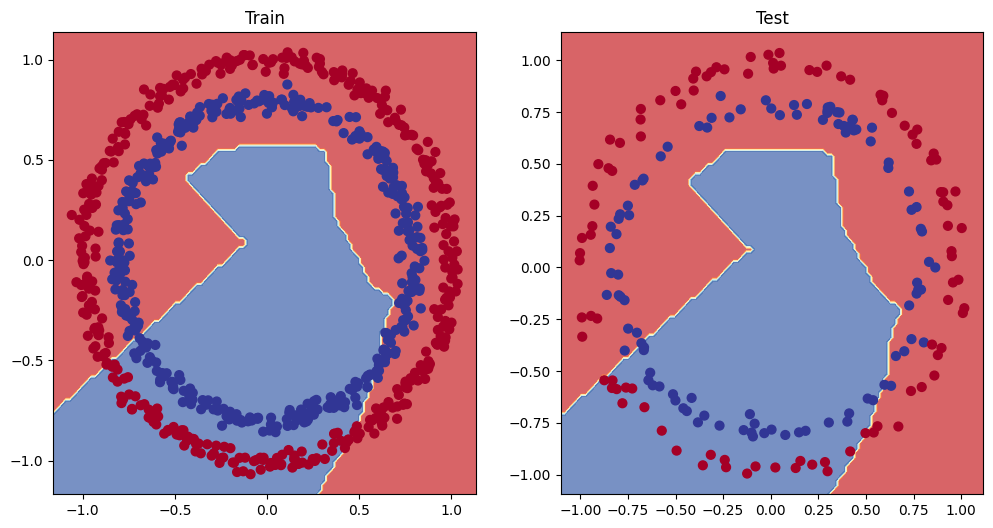

In [52]:
# Plot decision boundaries
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

## 7. Replicando non-linear actication function

Neural networks, rather than us telling the model what to learn, we give it the tools to discover patterns in data and it tries to figure out the patterns on its own

And these tools are linear and non-linear functions

In [53]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A.dtype

torch.float32

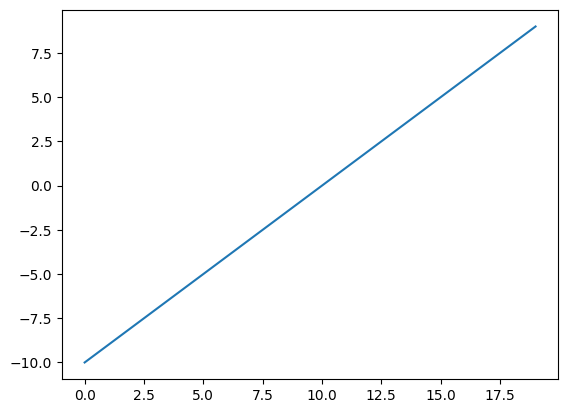

In [54]:
plt.plot(A)

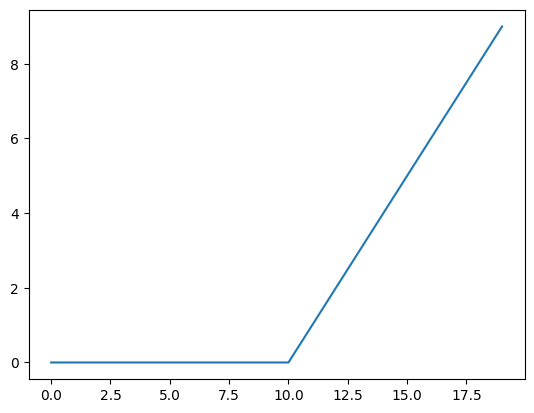

In [55]:
plt.plot(torch.relu(A))

In [56]:
def relu(x: torch.Tensor) -> torch.Tensor:
  return torch.maximum(torch.tensor(0), x)

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

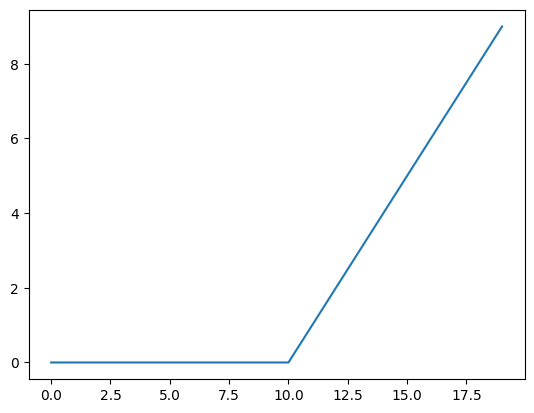

In [57]:
# plot ReLU  activation function
plt.plot(relu(A))

In [58]:
# Let's do the same for sigmoid
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

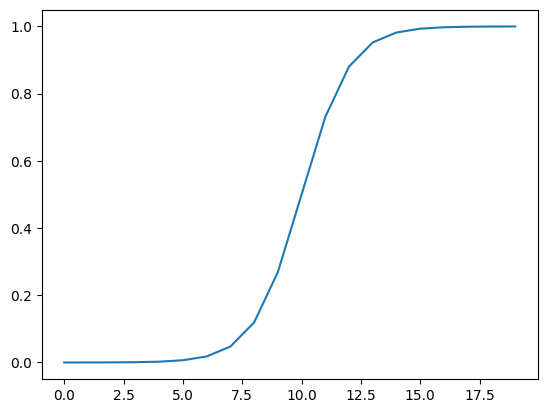

In [59]:
plt.plot(torch.sigmoid(A));

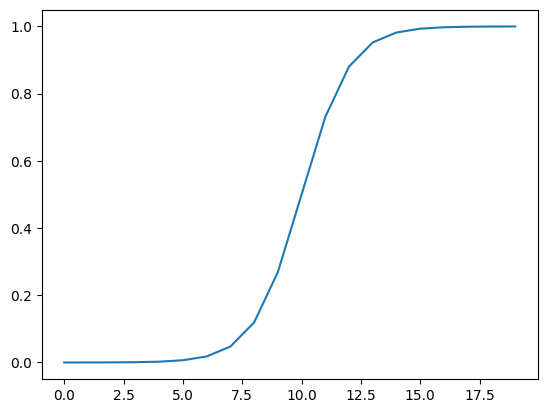

In [60]:
plt.plot(sigmoid(A))

## 8. Putting it all together with a multi-class classsification problem

* Binary classification = one thing or another
* Multi-class classification = more than one thing or another

### 8.1 Creating a toy multi-class dataset

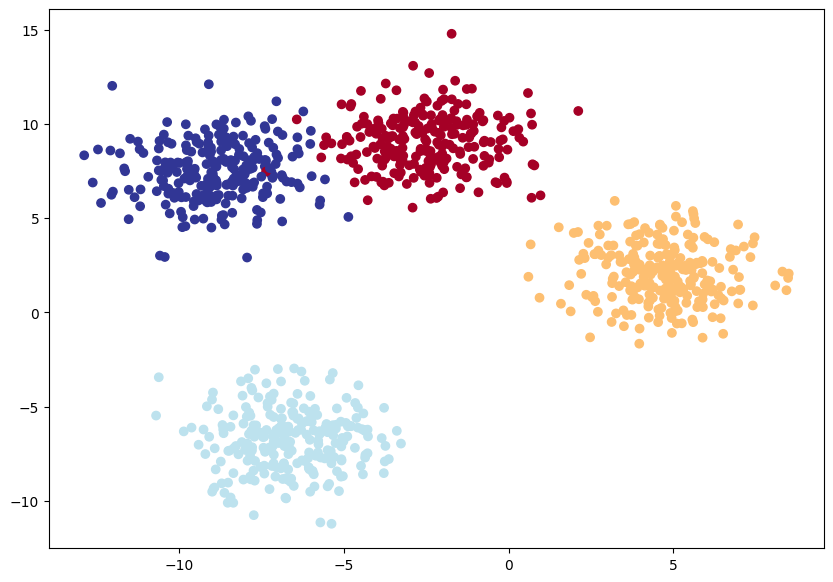

In [61]:
# import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob  =  make_blobs(n_samples=1000,
                              n_features=NUM_FEATURES,
                              centers=NUM_CLASSES,
                              cluster_std=1.5, # Give the clusters a little shake up (da uma misturada)
                              random_state=RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float32) # Float ou float32 são a mesma coisa, o padão do float é 32 no PyTprch
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
# 3. Split into training and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,  # Esse test size explica que eu quero 80% treino e 20% teste
                                                                        random_state=RANDOM_SEED)

# 4. Plot data (visualization)
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

### 8.2 Building a multi-class classification model in PyTorch

In [62]:
# Create a device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [63]:
# build a multi-class classification model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

# Crete an instance of BlobModel and send it to the target device

model_4 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)

model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [64]:
X_blob_train.shape,  y_blob_train[:5]

(torch.Size([800, 2]), tensor([1, 0, 2, 2, 0]))

## 8.3  Create a loss function and an optimizer for a multi-class classification model

In [65]:
# Create a loss and an optimizer function for multi-class classification

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1)

###  8.4 Getting prediction probabilities for a  multi-class PyTorch model

In order to  evaluate and train and test our model, we need to convert our model's outputs (logits) to prediction probabilities and than to prediction labels.

Logits (raw output of the model) -> pred probs (use `torch.softmax`) -> pred labels (take the argmax of the prediction probabilities)

In [66]:
# Let's get some raw outputs of our model (logits)
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test.to(device))

y_logits[:10]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834],
        [-0.1497, -1.0617, -0.7107, -0.1645],
        [ 0.1539, -0.2887,  0.1520, -0.0109],
        [-0.2154, -1.1795, -0.9300, -0.2745],
        [ 0.2443, -0.2472,  0.1649,  0.0061],
        [-0.2329, -1.2120, -0.9849, -0.3004]], device='cuda:0')

In [67]:
# Convert our model's logit outputs to prediction probabilities

y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], device='cuda:0')
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]], device='cuda:0')


In [68]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

In [69]:
# Convert our model's prediction probabilities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')

### 8.5 Crreating a training loop and testing loop for a multi-class Pytorch model

In [70]:
# Fit the multi-class model to the data

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
epochs = 100

# Put the data in the agnostic device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# Loop through data
for epoch in range(epochs):
  ### Training
  model_4.train()

  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits,  dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train,
                    y_pred=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  ### Let's test

  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits,  y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test,
                           y_pred=test_preds)

    # Print out what's happin'
    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.4f}, Acc: {acc:.2f}% | Test loss {test_loss:.4f}, Test acc: {test_acc:.2f}%")



Epoch: 0 | Loss: 1.1588, Acc: 40.38% | Test loss 1.0755, Test acc: 48.00%
Epoch: 10 | Loss: 0.6448, Acc: 96.75% | Test loss 0.6607, Test acc: 97.50%
Epoch: 20 | Loss: 0.4254, Acc: 98.50% | Test loss 0.4307, Test acc: 100.00%
Epoch: 30 | Loss: 0.2529, Acc: 99.12% | Test loss 0.2451, Test acc: 99.50%
Epoch: 40 | Loss: 0.1123, Acc: 99.25% | Test loss 0.1023, Test acc: 99.50%
Epoch: 50 | Loss: 0.0663, Acc: 99.25% | Test loss 0.0585, Test acc: 99.50%
Epoch: 60 | Loss: 0.0507, Acc: 99.25% | Test loss 0.0429, Test acc: 99.50%
Epoch: 70 | Loss: 0.0430, Acc: 99.25% | Test loss 0.0349, Test acc: 99.50%
Epoch: 80 | Loss: 0.0384, Acc: 99.25% | Test loss 0.0299, Test acc: 99.50%
Epoch: 90 | Loss: 0.0352, Acc: 99.25% | Test loss 0.0266, Test acc: 99.50%


### 8.6 Making and evaluating predictions with a PyTorch multi-class model

In [71]:
# Make predictions
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[-0.6249,  5.9860, -7.6323, -8.4470],
        [-2.1738, -6.3750, -3.7202,  3.1203],
        [-3.4102, -3.8958,  3.1567, -2.6119],
        [-1.1505,  4.1962, -3.8472, -4.8820],
        [ 3.7548, -1.3391, -9.1422, -6.9466],
        [-2.8211, -7.5767, -4.2944,  3.7944],
        [-3.0306, -3.3328,  2.7955, -2.1374],
        [ 3.3761, -4.0375, -6.8987, -3.5503],
        [-4.3620, -4.9904,  3.8123, -3.3814],
        [ 3.5012, -3.0281, -7.5401, -4.7064]], device='cuda:0')

In [72]:
# Go from logits -> Prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[1.3438e-03, 9.9865e-01, 1.2164e-06, 5.3854e-07],
        [4.9905e-03, 7.4740e-05, 1.0630e-03, 9.9387e-01],
        [1.3985e-03, 8.6060e-04, 9.9463e-01, 3.1073e-03],
        [4.7389e-03, 9.9483e-01, 3.1956e-04, 1.1353e-04],
        [9.9388e-01, 6.0966e-03, 2.4904e-06, 2.2378e-05],
        [1.3372e-03, 1.1504e-05, 3.0644e-04, 9.9834e-01],
        [2.9138e-03, 2.1537e-03, 9.8781e-01, 7.1181e-03],
        [9.9838e-01, 6.0198e-04, 3.4435e-05, 9.7989e-04],
        [2.8147e-04, 1.5016e-04, 9.9882e-01, 7.5044e-04],
        [9.9825e-01, 1.4575e-03, 1.5998e-05, 2.7210e-04]], device='cuda:0')

In [73]:
# Go from pred probs to pred label
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 0, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1], device='cuda:0')

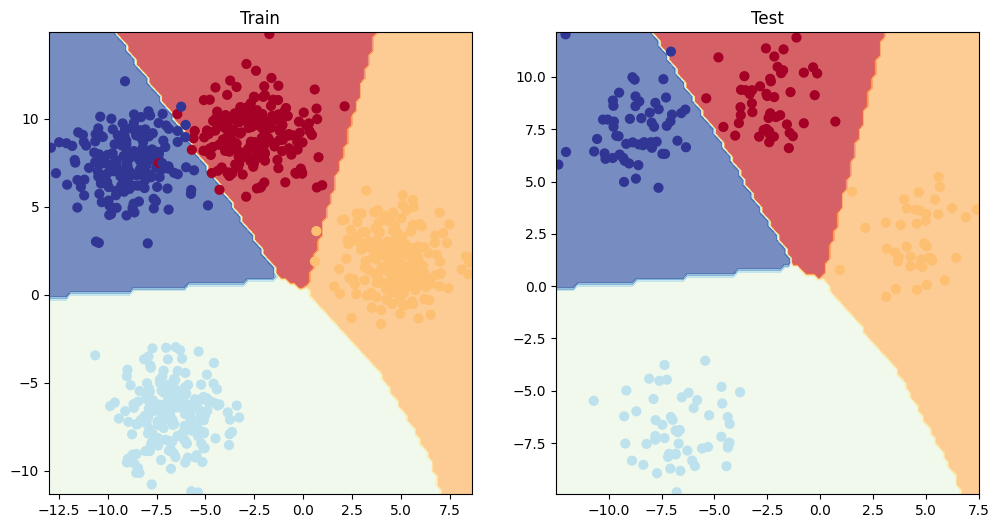

In [74]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

### 9.  A few more classification metrics... ( to evaluate our classification model)

* Accuracy - out of 100 samples, how many does our model get right?
* Precision
* Recall
* F1-score
* Confusion matrix
* Classification report

See this article for when to use precision and recall: https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c